<a href="https://colab.research.google.com/github/hublun/Bayesian_Aggregation_Average_Data/blob/master/ODR_2024_1_22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
install.packages("rstan", repos = c("https://mc-stan.org/r-packages/", getOption("repos")))

Installing package into ‘/home/dulunche/R/x86_64-pc-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)

also installing the dependencies ‘StanHeaders’, ‘RcppEigen’




In [1]:
library(rstan)

Loading required package: StanHeaders


rstan version 2.32.5 (Stan version 2.32.2)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)




In [2]:
parallel::detectCores()

[1] 8

In [3]:
example(stan_model, package = "rstan", run.dontrun = TRUE)


stn_md> stancode <- 'data {real y_mean;} parameters {real y;} model {y ~ normal(y_mean,1);}'

stn_md> mod <- stan_model(model_code = stancode, verbose = TRUE)

TRANSLATING MODEL '' FROM Stan CODE TO C++ CODE NOW.
OS: x86_64, linux-gnu; rstan: 2.32.5; Rcpp: 1.0.11; inline: 0.3.19 
 >> setting environment variables: 
PKG_LIBS =  '/home/dulunche/R/x86_64-pc-linux-gnu-library/4.3/rstan/lib//libStanServices.a' -L'/home/dulunche/R/x86_64-pc-linux-gnu-library/4.3/StanHeaders/lib/' -lStanHeaders -L'/home/dulunche/R/x86_64-pc-linux-gnu-library/4.3/RcppParallel/lib/' -ltbb 
PKG_CPPFLAGS =   -I"/home/dulunche/R/x86_64-pc-linux-gnu-library/4.3/Rcpp/include/"  -I"/home/dulunche/R/x86_64-pc-linux-gnu-library/4.3/RcppEigen/include/"  -I"/home/dulunche/R/x86_64-pc-linux-gnu-library/4.3/RcppEigen/include/unsupported"  -I"/home/dulunche/R/x86_64-pc-linux-gnu-library/4.3/BH/include" -I"/home/dulunche/R/x86_64-pc-linux-gnu-library/4.3/StanHeaders/include/src/"  -I"/home/dulunche/R/x86_64-pc-linux-gnu-lib



---



In [4]:
install.packages('outbreaks')

Installing package into ‘/home/dulunche/R/x86_64-pc-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)



In [5]:
library(outbreaks)
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.3     ✔ purrr   0.3.4
✔ tibble  3.2.1     ✔ dplyr   1.1.3
✔ tidyr   1.2.1     ✔ stringr 1.5.0
✔ readr   2.1.2     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::extract() masks rstan::extract()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()


In [6]:
head(influenza_england_1978_school)

,date,in_bed,convalescent
,<date>,<int>,<int>
1,1978-01-22,3,0
2,1978-01-23,8,0
3,1978-01-24,26,0
4,1978-01-25,76,0
5,1978-01-26,225,9
6,1978-01-27,298,17


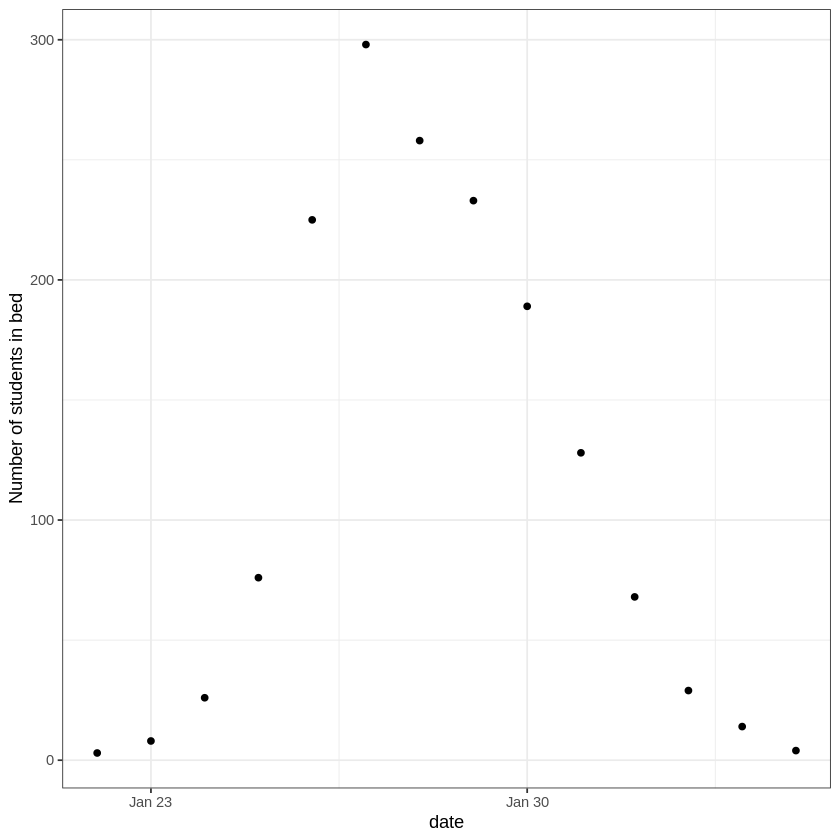

In [7]:
theme_set(theme_bw())
ggplot(data = influenza_england_1978_school) +
  geom_point(mapping = aes(x = date, y = in_bed)) +
  labs(y = "Number of students in bed")

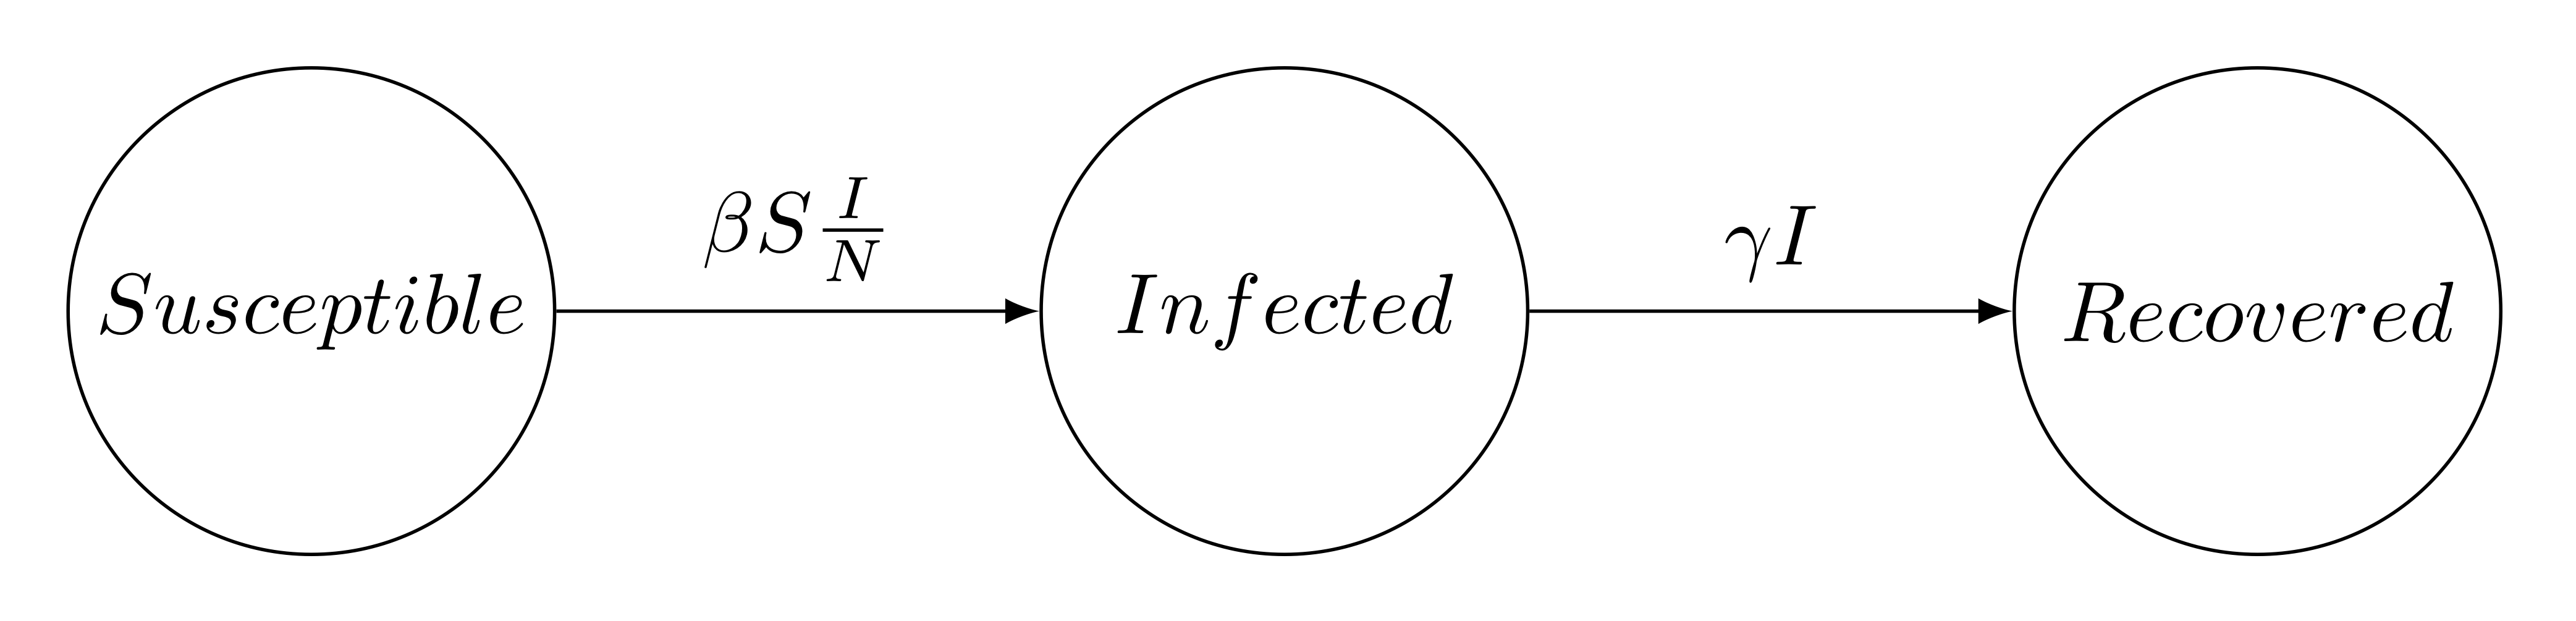

\begin{aligned}
 \frac{dS}{dt} &= -\beta  S \frac{I}{N}\\
 \frac{dI}{dt} &= \beta  S  \frac{I}{N} - \gamma  I \\
 \frac{dR}{dt} &= \gamma I
\end{aligned}


S(t)
 is the number of people susceptible to becoming infected (no immunity),

I(t)
 is the number of people currently infected (and infectious),

R(t)
 is the number of recovered people (we assume they remain immune indefinitely),

β
 is the constant rate of infectious contact between people,

γ
 the constant recovery rate of infected individuals.

In case of boarding school data, the spread of the disease has started with one infected individual which leads to the initial conditions I(0)=1,S(0)=N−1,R(0)=0.

#### The negative binomial distribution is a probability distribution that models the number of failures before a specified number of successes occur in a sequence of independent Bernoulli trials. It is a two-parameter distribution, with the first parameter representing the number of failures and the second parameter representing the probability of success in each trial.

In [9]:
model <- stan_model("./sir.stan")

In [13]:
dim(influenza_england_1978_school)

[1] 14  3

In [11]:
# time series of cases
cases <- influenza_england_1978_school$in_bed  # Number of students in bed

# total count
N <- 763;

# times
n_days <- length(cases) 
t <- seq(0, n_days, by = 1)
t0 = 0 
t <- t[-1]

#initial conditions
i0 <- 1
s0 <- N - i0
r0 <- 0
y0 = c(S = s0, I = i0, R = r0)

# data for Stan
data_sir <- list(n_days = n_days, 
                    y0 = y0, 
                    t0 = t0, 
                    ts = t, 
                    N = N, 
                    cases = cases
                )

# number of MCMC steps
niter <- 2000

In [14]:
t

[1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14

In [12]:
fit_sir_negbin <- sampling(model,
                data = data_sir,
                iter = niter,
                chains = 4, 
                seed = 0)


SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000181 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 1.81 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 3.062 seconds (Warm-up)
Chain 1:                2.75 seconds (Sampling)
Chain 1:                5.81

In [15]:
pars=c('beta', 'gamma', "R0", "recovery_time")

In [16]:
print(fit_sir_negbin, pars = pars)

Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
beta          1.73    0.00 0.05 1.64 1.70 1.73 1.77  1.85  2529    1
gamma         0.54    0.00 0.05 0.46 0.51 0.54 0.57  0.64  2454    1
R0            3.21    0.01 0.27 2.73 3.03 3.19 3.37  3.83  2516    1
recovery_time 1.85    0.00 0.15 1.56 1.75 1.84 1.95  2.18  2495    1

Samples were drawn using NUTS(diag_e) at Mon Jan 22 15:30:41 2024.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


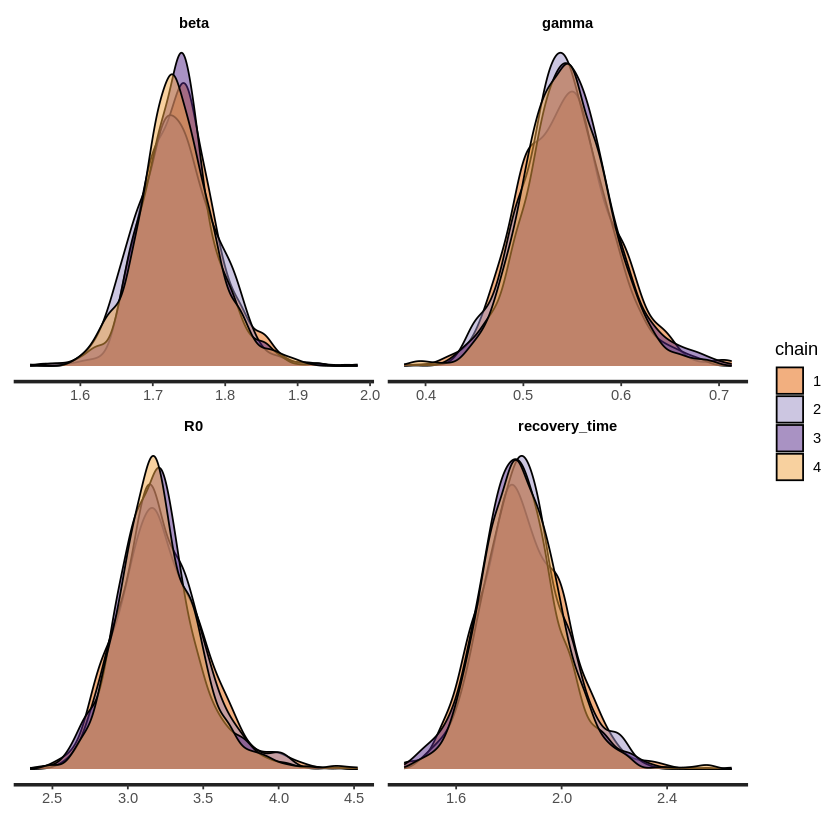

In [17]:
stan_dens(fit_sir_negbin, pars = pars, separate_chains = TRUE)